In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np

In [4]:
import sys
import os
from collections import defaultdict, Counter

In [5]:
import math

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

## Constants

In [7]:
data_path = "/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability"

## Get paths of files

In [8]:
base_file_dict = defaultdict(list)
tax_registry_c_1_file_dict = defaultdict(list)
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path.endswith('parquet'):
            file_type = 'train' if 'train' in file_path else 'test'
            if 'base' in file_path:
                base_file_dict[file_type].append(file_path)
            if 'tax_registry_c_1' in file_path:
                tax_registry_c_1_file_dict[file_type].append(file_path)

In [9]:
tax_registry_c_1_file_dict.get("train")

['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_tax_registry_c_1.parquet']

## Functions

In [10]:
def get_column_description(feature_def_df, column_name):
    return feature_def_df[feature_def_df.Variable == column_name]['Description'].iloc[0]

In [11]:
def plot_scatterplot(df, x_col_name, y_col_name, show_x_y_line=False):
    assert x_col_name in df.columns, f"Ensure that {x_col_name} is in the df"
    assert y_col_name in df.columns, f"Ensure that {y_col_name} is in the df"
    
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x=df[x_col_name], y=df[y_col_name], ax=axs)
    
    if show_x_y_line:
        df[x_col_name] = df[x_col_name].replace([np.inf, -np.inf], np.nan)
        df[y_col_name] = df[y_col_name].replace([np.inf, -np.inf], np.nan)
        not_null_x_filter = ~df[x_col_name].isnull()
        not_null_y_filter = ~df[y_col_name].isnull()
        not_null_filter = not_null_x_filter & not_null_y_filter
        filtered_df = df[not_null_filter]
        x_values_series = filtered_df[x_col_name]
        y_values_series = filtered_df[y_col_name]
        x0, x1 = min(x_values_series), max(x_values_series)
        y0, y1 = min(y_values_series), max(y_values_series)
        #line_values = [i for i in np.arange(min(x0, y0), max(x1, y1), 0.1)]
        lims = [min(x0, y0), max(x1, y1)]
        print(f"lims: {lims}")
        plt.plot(lims, lims)
    return fig

In [12]:
def get_percent_of_column(df, groupby_column, target_column):
    target_df = df.groupby(by=[groupby_column]).agg({target_column:"sum"}).reset_index()
    all_rows_df = df.groupby(by=[groupby_column]).size().reset_index().rename({0:"total_rows"}, axis=1)
    merged_df = target_df.merge(all_rows_df, left_on=[groupby_column], right_on=[groupby_column], how="left")
    merged_df["percentage_default"] = 100*merged_df["target"]/merged_df["total_rows"]
    merged_df[groupby_column] = merged_df[groupby_column].astype(str)
    return merged_df

In [13]:
def plot_barplot(df, percent_column, category_column):
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.barplot(ax=ax, data=df, y=category_column, x=percent_column, order=df.sort_values(by=[percent_column], ascending=False)[category_column].values)
    return fig

In [14]:
def get_relevant_indices(series):
    percentile_25 = series.quantile(0.25)
    percentile_75 = series.quantile(0.75)
    iqr = percentile_75-percentile_25
    upper_limit = percentile_75 + 1.5*iqr
    lower_limit = percentile_25 - 1.5*iqr

    keep_indices = series[(series>=lower_limit) & (series<=upper_limit)].index
    return keep_indices 

## Read datasets

In [15]:
feature_df = pd.read_csv(f"{data_path}/feature_definitions.csv")
print(f"Shape of feature_df: {feature_df.shape}")

Shape of feature_df: (465, 2)


In [16]:
train_base_df = pd.concat([pd.read_parquet(file_path) for file_path in base_file_dict['train']], axis=0)
print(f"Shape of train_base_df: {train_base_df.shape}")

Shape of train_base_df: (1526659, 5)


## Properties: depth=1, internal data source

In [17]:
tax_registry_c_1_df = pd.concat([pd.read_parquet(file_path) for file_path in tax_registry_c_1_file_dict['train']], axis=0)
print(f"Shape of tax_registry_c_1_df: {tax_registry_c_1_df.shape}")

Shape of tax_registry_c_1_df: (3343800, 5)


In [18]:
tax_registry_c_1_df.columns.unique()

Index(['case_id', 'employername_160M', 'num_group1', 'pmtamount_36A',
       'processingdate_168D'],
      dtype='object')

In [20]:
train_base_df["date_decision"] = pd.to_datetime(train_base_df["date_decision"])

tax_registry_c_1_df["processingdate_168D"] = pd.to_datetime(tax_registry_c_1_df["processingdate_168D"])

## This means that there are multiple rows for each case_id indexed by num_group1

In [21]:
unique_num_group_case_id_df = tax_registry_c_1_df.groupby(by=["case_id"]).agg({"num_group1": "nunique"}).reset_index().rename({"num_group1": "generated_count_of_tax_information_by_provider_c"}, axis=1)

In [22]:
unique_num_group_case_id_df[unique_num_group_case_id_df.generated_count_of_tax_information_by_provider_c>10].sort_values(by=["generated_count_of_tax_information_by_provider_c"]).head(5)

,case_id,generated_count_of_tax_information_by_provider_c
482264,2629815,11
135554,712683,11
344817,1438634,11
344820,1438640,11
135522,712639,11


In [23]:
tax_registry_c_1_df[tax_registry_c_1_df.case_id == 1846104].sort_values(by=["num_group1"]).head()

,case_id,employername_160M,num_group1,pmtamount_36A,processingdate_168D


<Axes: ylabel='generated_count_of_tax_information_by_provider_c'>

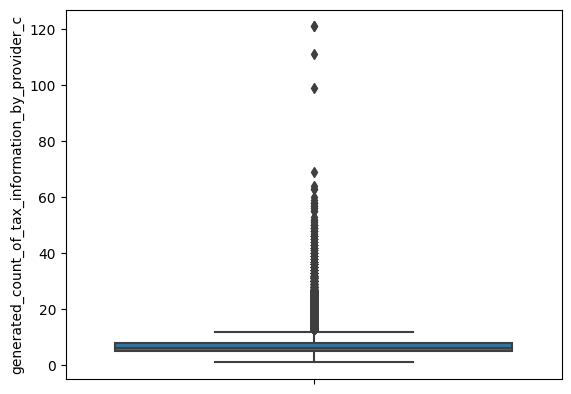

In [24]:
sns.boxplot(data=unique_num_group_case_id_df, y="generated_count_of_tax_information_by_provider_c")

## Number of tax related records provided for case_ids vary from 1 to 99

### 1. processingdate_168D

In [26]:
get_column_description(feature_df, "processingdate_168D")

'Date when the tax deduction is processed.'

In [28]:
tax_registry_c_1_df.processingdate_168D.isnull().value_counts()

processingdate_168D
False    3343800
Name: count, dtype: int64

In [29]:
## Check across how unique dates are tax deduction records for a given case_id
statistics_processingdate_168D_for_case_id_df = tax_registry_c_1_df.groupby(by=["case_id"]).agg({"processingdate_168D": ["nunique", "max"]}).reset_index()
statistics_processingdate_168D_for_case_id_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_processingdate_168D_for_case_id_df.columns]

In [30]:
statistics_processingdate_168D_for_case_id_df.head(2)

,case_id,generated_processingdate_168D_nunique,generated_processingdate_168D_max
0,357,6,2019-01-04
1,381,5,2018-12-27


In [31]:
print(f"Minimum number of unique dates associated with case_id: {statistics_processingdate_168D_for_case_id_df['generated_processingdate_168D_nunique'].min()}")
print(f"Maximum number of unique dates associated with case_id: {statistics_processingdate_168D_for_case_id_df['generated_processingdate_168D_nunique'].max()}")

Minimum number of unique dates associated with case_id: 1
Maximum number of unique dates associated with case_id: 38


## A case_id is associated with 1 to 38 unique dates

## Is this the date on which tax deduction record was provided by the registry to homecredit instead of the date of tx deduction??

In [32]:
print(f"Min processingdate_168D: {tax_registry_c_1_df.processingdate_168D.min()}")
print(f"Max processingdate_168D: {tax_registry_c_1_df.processingdate_168D.max()}")

Min processingdate_168D: 2018-07-11 00:00:00
Max processingdate_168D: 2019-10-22 00:00:00


## This record information is obtained across an year...

In [33]:
merged_train_base_statistics_processingdate_168D_for_case_id_df = train_base_df.merge(statistics_processingdate_168D_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_processingdate_168D_for_case_id_df: {merged_train_base_statistics_processingdate_168D_for_case_id_df.shape}")

Shape of merged_train_base_statistics_processingdate_168D_for_case_id_df: (1526659, 7)


In [34]:
merged_train_base_statistics_processingdate_168D_for_case_id_df.head(2)

,case_id,date_decision,MONTH,WEEK_NUM,target,generated_processingdate_168D_nunique,generated_processingdate_168D_max
0,0,2019-01-03,201901,0,0,NaN,NaT
1,1,2019-01-03,201901,0,0,NaN,NaT


In [35]:
merged_train_base_statistics_processingdate_168D_for_case_id_df["day_gap_between_processingdate_168D_and_date_decision"] = (merged_train_base_statistics_processingdate_168D_for_case_id_df["generated_processingdate_168D_max"]-merged_train_base_statistics_processingdate_168D_for_case_id_df["date_decision"]).dt.days

<Axes: xlabel='target', ylabel='day_gap_between_processingdate_168D_and_date_decision'>

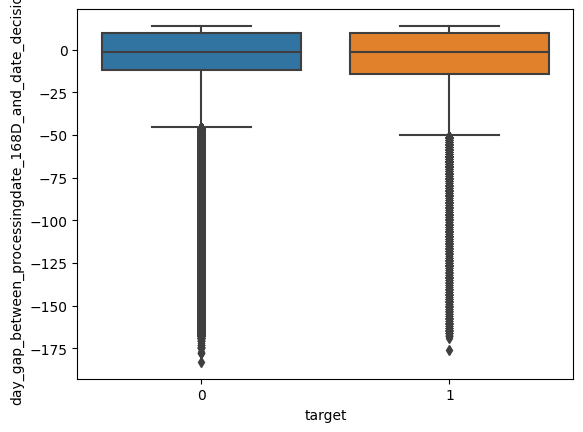

In [36]:
sns.boxplot(data=merged_train_base_statistics_processingdate_168D_for_case_id_df, y="day_gap_between_processingdate_168D_and_date_decision", x="target")

## Some tax deduction was done before date_decision and some after.  

In [37]:
merged_train_base_statistics_processingdate_168D_for_case_id_df[~merged_train_base_statistics_processingdate_168D_for_case_id_df.generated_processingdate_168D_nunique.isnull()]["day_gap_between_processingdate_168D_and_date_decision"].value_counts()

day_gap_between_processingdate_168D_and_date_decision
 14.0     74788
 10.0     13339
 12.0     13313
 11.0     13267
 9.0      12498
          ...  
-178.0        3
-172.0        2
-176.0        1
-177.0        1
-183.0        1
Name: count, Length: 194, dtype: int64

### 2. pmtamount_36A

In [38]:
get_column_description(feature_df, "pmtamount_36A")

'Tax deductions amount for credit bureau payments.'

In [39]:
statistics_pmtamount_36A_df = tax_registry_c_1_df.groupby(by=["case_id"]).agg({"pmtamount_36A": ["max", "min", "mean"]}).reset_index()
statistics_pmtamount_36A_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_pmtamount_36A_df.columns]

In [42]:
statistics_pmtamount_36A_df.sort_values(by=["case_id"]).head()

,case_id,generated_pmtamount_36A_max,generated_pmtamount_36A_min,generated_pmtamount_36A_mean
0,357,1200.00000,628.600040,1050.233340
1,381,690.60004,665.800000,669.933340
2,388,2708.40010,2200.000000,2424.666683
3,405,2933.10000,742.060000,1749.706700
4,409,1610.73400,69.840004,906.411402


### 3. employername_160M

In [43]:
get_column_description(feature_df, "employername_160M")

"Employer's name."

In [45]:
statistics_employername_160M_for_case_id_df = tax_registry_c_1_df.groupby(by=["case_id"]).agg(generated_employername_160M_nunique=pd.NamedAgg(column="employername_160M", aggfunc="nunique"), generated_employername_160M_mode=pd.NamedAgg(column="employername_160M", aggfunc=lambda x:x.value_counts().index[0]))

In [46]:
statistics_employername_160M_for_case_id_df

,generated_employername_160M_nunique,generated_employername_160M_mode
case_id,,
357,1,c91b12ff
381,1,8026f2a0
388,1,34cb7f48
405,2,6771878b
409,1,1d197dc0
...,...,...
2629807,2,1350d5dd
2629808,2,ebf172fc
2629809,2,f7202a88


Use tax_registry b and c